In [1]:
import numpy as np
from collections import Counter

def load_and_preprocess_data(file_path):
    data = np.genfromtxt(file_path, delimiter=',', dtype=str, skip_header=2)
    X = data[:, :-1].astype(float)
    y = (data[:, -1] == '1').astype(int) * 2 - 1

    # Split the data
    np.random.seed(2)
    total_samples = len(X)
    train_size = 24000
    indices = np.random.permutation(total_samples)
    X_train, X_test = X[indices[:train_size]], X[indices[train_size:]]
    y_train, y_test = y[indices[:train_size]], y[indices[train_size:]]

    # Binarize features
    for col in range(X_train.shape[1]):
        median = np.median(X_train[:, col])
        X_train[:, col] = (X_train[:, col] > median).astype(int)
        X_test[:, col] = (X_test[:, col] > median).astype(int)

    return X_train, X_test, y_train, y_test

class DecisionTreeStump:
    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.feature = np.random.randint(self.n_features)
        self.threshold = np.median(X[:, self.feature])
        left = y[X[:, self.feature] <= self.threshold]
        right = y[X[:, self.feature] > self.threshold]
        self.left_pred = 1 if np.sum(left) > 0 else -1
        self.right_pred = 1 if np.sum(right) > 0 else -1

    def predict(self, X):
        return np.where(X[:, self.feature] <= self.threshold, self.left_pred, self.right_pred)

def plot_results(results, title):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 501), results['train_errors'], 'b-', label='Train Error')
    plt.plot(range(1, 501), results['test_errors'], 'r-', label='Test Error')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Error Rate')
    plt.title(title)
    plt.legend()
    plt.show()


In [5]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (self.max_depth is not None and depth >= self.max_depth) or n_labels == 1:
            return np.sign(np.sum(y))  # Return the majority class (-1 or 1)

        feature_idx = np.random.randint(n_features)
        threshold = np.median(X[:, feature_idx])

        left_idx = X[:, feature_idx] <= threshold
        right_idx = X[:, feature_idx] > threshold

        left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)

        return (feature_idx, threshold, left, right)

    def predict(self, X):
        return np.array([self._predict_tree(x, self.tree) for x in X])

    def _predict_tree(self, x, tree):
        if isinstance(tree, (int, np.int64)):  # Changed this line
            return tree
        feature_idx, threshold, left, right = tree
        if x[feature_idx] <= threshold:
            return self._predict_tree(x, left)
        else:
            return self._predict_tree(x, right)

def bagged_trees(X_train, y_train, X_test, y_test, n_estimators=500, max_depth=10):
    trees = []
    n_samples = X_train.shape[0]
    train_errors, test_errors = [], []

    for _ in range(n_estimators):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        X_sample, y_sample = X_train[indices], y_train[indices]
        
        tree = DecisionTree(max_depth=max_depth)
        tree.fit(X_sample, y_sample)
        trees.append(tree)

        y_train_pred = np.sign(np.sum([tree.predict(X_train) for tree in trees], axis=0))
        y_test_pred = np.sign(np.sum([tree.predict(X_test) for tree in trees], axis=0))

        train_errors.append(np.mean(y_train_pred != y_train))
        test_errors.append(np.mean(y_test_pred != y_test))

    return {'train_errors': train_errors, 'test_errors': test_errors}

if __name__ == "__main__":
    X_train, X_test, y_train, y_test = load_and_preprocess_data("default of credit card clients.csv")
    results = bagged_trees(X_train, y_train, X_test, y_test)
    plot_results(results, "Bagged Trees Performance")

c:\Users\raoge\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\raoge\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

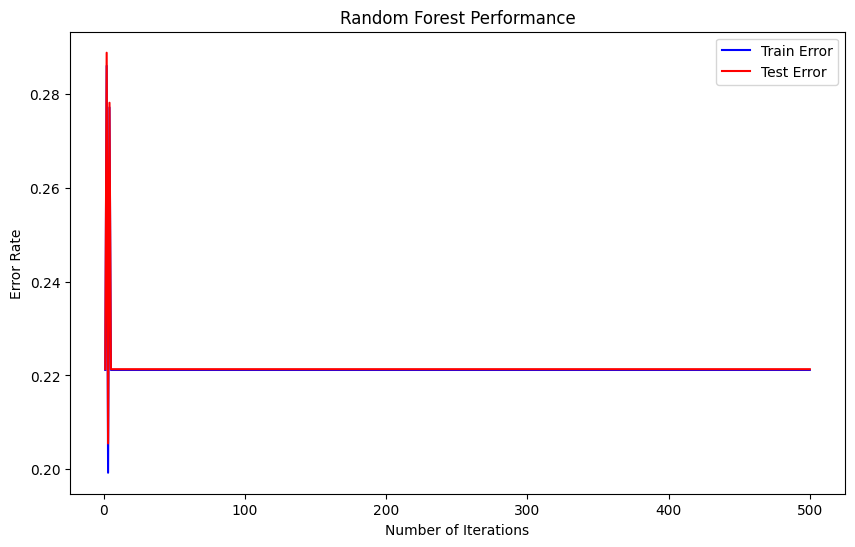

In [3]:
def random_forest(X_train, y_train, X_test, y_test, n_estimators=500):
    trees = []
    train_errors, test_errors = [], []

    for _ in range(n_estimators):
        indices = np.random.choice(len(X_train), len(X_train), replace=True)
        X_sample, y_sample = X_train[indices], y_train[indices]
        
        tree = DecisionTreeStump()
        tree.fit(X_sample, y_sample)
        trees.append(tree)

        y_train_pred = np.sign(np.sum([t.predict(X_train) for t in trees], axis=0))
        y_test_pred = np.sign(np.sum([t.predict(X_test) for t in trees], axis=0))

        train_errors.append(np.mean(y_train_pred != y_train))
        test_errors.append(np.mean(y_test_pred != y_test))

    return {'train_errors': train_errors, 'test_errors': test_errors}

if __name__ == "__main__":
    X_train, X_test, y_train, y_test = load_and_preprocess_data("default of credit card clients.csv")
    results = random_forest(X_train, y_train, X_test, y_test)
    plot_results(results, "Random Forest Performance")

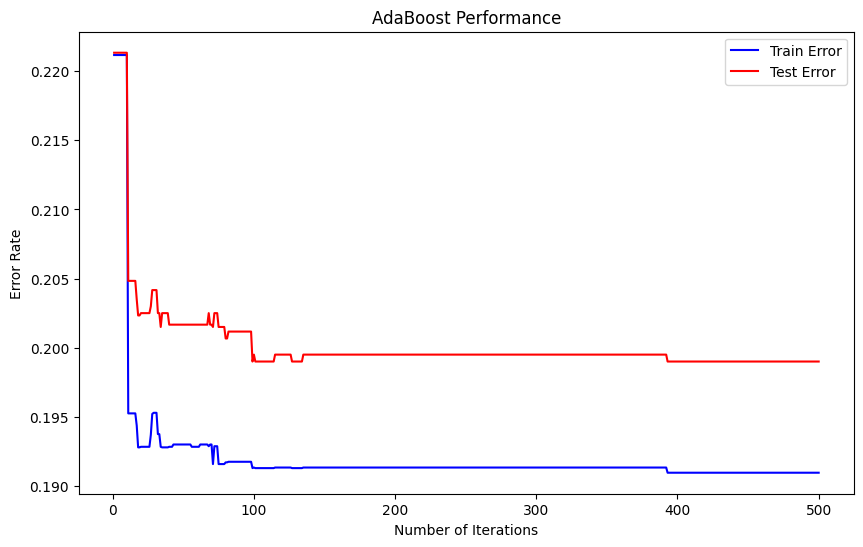

In [4]:
def adaboost(X_train, y_train, X_test, y_test, n_estimators=500):
    n_samples = len(X_train)
    w = np.full(n_samples, (1 / n_samples))
    stumps = []
    alpha = []
    train_errors, test_errors = [], []

    for _ in range(n_estimators):
        stump = DecisionTreeStump()
        stump.fit(X_train, y_train)
        
        y_pred = stump.predict(X_train)
        err = np.sum(w * (y_pred != y_train)) / np.sum(w)
        
        stump_weight = 0.5 * np.log((1 - err) / (err + 1e-10))
        
        w *= np.exp(-stump_weight * y_train * y_pred)
        w /= np.sum(w)

        stumps.append(stump)
        alpha.append(stump_weight)

        y_train_pred = np.sign(np.sum([a * s.predict(X_train) for a, s in zip(alpha, stumps)], axis=0))
        y_test_pred = np.sign(np.sum([a * s.predict(X_test) for a, s in zip(alpha, stumps)], axis=0))

        train_errors.append(np.mean(y_train_pred != y_train))
        test_errors.append(np.mean(y_test_pred != y_test))

    return {'train_errors': train_errors, 'test_errors': test_errors}

if __name__ == "__main__":
    X_train, X_test, y_train, y_test = load_and_preprocess_data("default of credit card clients.csv")
    results = adaboost(X_train, y_train, X_test, y_test)
    plot_results(results, "AdaBoost Performance")